# Inference using PSSR EM model

In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
import libtiff
import skimage
import skimage.filters
from utils.utils import FeatureLoss
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_float32, img_as_ubyte

/home/ashaw/anaconda3/envs/fastai/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# torch.cuda.set_device(1)

In [3]:
def tif_predict_movie_blend_slices(learn, tif_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
        data = libtiff.TiffFile(tif_in)
        data = data.get_tiff_array()
        depths = data.shape[0]
        img_max = None        
        for depth in progress_bar(list(range(depths))):
            img = data[depth].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            img = img[np.newaxis, :]
            out_img = unet_image_from_tiles_blend(learn, img, tile_sz=size)
            pred = (out_img[None]*255).astype(np.uint8)
            pred_img_out = pred_out+f'_slice{depth}.tif'
            skimage.io.imsave(pred_img_out,pred)        

In [4]:
# take float in with info about mi,ma,max in and spits out (0-1.0)
def unet_image_from_tiles_blend(learn, in_img, tile_sz=256, scale=4, overlap_pct=5.0, img_info=None):
    n_frames = in_img.shape[0]    

    if img_info:
        mi, ma, imax = [img_info[fld] for fld in ['mi','ma','img_max']]
        in_img = ((in_img - mi) / (ma - mi + 1e-20)).clip(0.,1.)
    else:
        mi, ma = 0., 1.

    in_img  = np.stack([npzoom(in_img[i], scale, order=1) for i in range(n_frames)])
    overlap = int(tile_sz*(overlap_pct/100.) // 2 * 2)
    step_sz = tile_sz - overlap
    h,w = in_img.shape[1:3]
    assembled = np.zeros((h,w))

    x_seams = set()
    y_seams = set()

    for x_tile in range(0,math.ceil(w/step_sz)):
        for y_tile in range(0,math.ceil(h/step_sz)):
            x_start = x_tile*step_sz
            x_end = min(x_start + tile_sz, w)
            y_start = y_tile*step_sz
            y_end = min(y_start + tile_sz, h)
            src_tile = in_img[:,y_start:y_end,x_start:x_end]


            in_tile = torch.zeros((tile_sz, tile_sz, n_frames))
            in_x_size = x_end - x_start
            in_y_size = y_end - y_start
            if (in_y_size, in_x_size) != src_tile.shape[1:3]: set_trace()
            in_tile[0:in_y_size, 0:in_x_size, :] = tensor(src_tile).permute(1,2,0)

            if n_frames > 1:
                img_in = MultiImage([Image(in_tile[:,:,i][None]) for i in range(n_frames)])
            else:
                img_in = Image(in_tile[:,:,0][None])
            pred, _, _ = learn.predict(img_in)
                        
            out_tile = pred.data.numpy()[0]
            
            half_overlap = overlap // 2
            left_adj = half_overlap if x_start != 0 else 0
            right_adj = half_overlap if x_end != w else 0
            top_adj = half_overlap if y_start != 0 else 0
            bot_adj = half_overlap if y_end != h else 0

            trim_y_start = y_start + top_adj
            trim_x_start = x_start + left_adj
            trim_y_end = y_end - bot_adj
            trim_x_end = x_end - right_adj

            out_x_start = left_adj
            out_y_start = top_adj
            out_x_end = in_x_size - right_adj
            out_y_end = in_y_size - bot_adj

            assembled[trim_y_start:trim_y_end, trim_x_start:trim_x_end] = out_tile[out_y_start:out_y_end, out_x_start:out_x_end]

            if trim_x_start != 0: x_seams.add(trim_x_start)
            if trim_y_start != 0: y_seams.add(trim_y_start)

    blur_rects = []
    blur_size = 5
    for x_seam in x_seams:
        left = x_seam - blur_size
        right = x_seam + blur_size
        top, bottom = 0, h
        blur_rects.append((slice(top, bottom), slice(left, right)))

    for y_seam in y_seams:
        top = y_seam - blur_size
        bottom = y_seam + blur_size
        left, right = 0, w
        blur_rects.append((slice(top, bottom), slice(left, right)))

    for xs,ys in blur_rects:
        assembled[xs,ys] = skimage.filters.gaussian(assembled[xs,ys], sigma=1.0)
        
    if assembled.min() < 0: assembled -= assembled.min() 

    return assembled.astype(np.float32)

## Set path for test sets

In [5]:
# Modify accordingly
testset_path = Path('stats') 
# testset_name = 'EM_aligned_lr'
testset_name = 'invivo'

lr_path = testset_path/f'input/{testset_name}'
results = testset_path/f'output/{testset_name}'
test_files = list(lr_path.glob('*.tif'))

if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)

print('Processing '+str(len(test_files))+' files...')

Processing 7 files...


In [7]:
lr_path

PosixPath('stats/input/invivo')

In [8]:
testset_path

PosixPath('stats')

## Load PSSR model

In [9]:
model_name = 'PSSR_EM_1024'
learn = load_learner('models', f'{model_name}.pkl').to_fp16()
# learn.model = learn.model.cpu()
size = int(model_name.split('_')[-1])
print(f'{model_name} model is being used.')

/home/ashaw/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ashaw/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ashaw/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve 

PSSR_EM_1024 model is being used.


In [10]:
def set_blur(m:nn.Module, blur=False)->None:
    "Set bn layers in eval mode for all recursive children of `m`."
    for l in m.children():
        if isinstance(l, PixelShuffle_ICNR):
            l.do_blur = blur
        set_blur(l)

In [11]:
set_blur(learn.model)

## Inference

In [12]:
for fn in test_files:
    print(f'Processing:{fn.stem}')
    pred_name = str(results/f'{fn.stem}_pred')
    orig_name = results/f'{fn.stem}_orig.tif'
    tif_predict_movie_blend_slices(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

Processing:03


Processing:07


Processing:06


Processing:05


Processing:01


Processing:04


Processing:02


In [13]:
print('All done!')

All done!


In [19]:
fn_lrs = sorted(lr_path.ls())

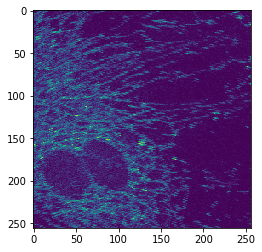

In [30]:
lr_img = plt.imread(sorted(lr_path.ls())[0])
plt.imshow(lr_img)

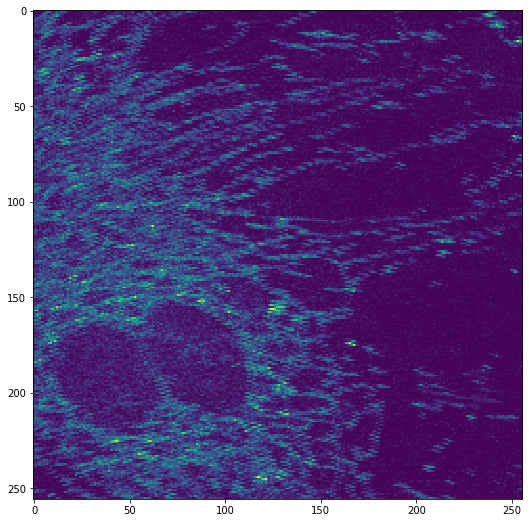

In [31]:
plt.figure(figsize=(9,9))
plt.imshow(lr_img)

In [23]:
lr_img.shape

(256, 256)

In [17]:
fn_results = list(sorted(results.ls())); fn_results

[PosixPath('stats/output/invivo/01_pred_slice0.tif'),
 PosixPath('stats/output/invivo/02_pred_slice0.tif'),
 PosixPath('stats/output/invivo/03_pred_slice0.tif'),
 PosixPath('stats/output/invivo/04_pred_slice0.tif'),
 PosixPath('stats/output/invivo/05_pred_slice0.tif'),
 PosixPath('stats/output/invivo/06_pred_slice0.tif'),
 PosixPath('stats/output/invivo/07_pred_slice0.tif')]

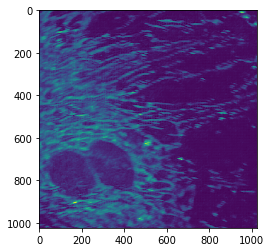

In [24]:
result_img = plt.imread(fn_results[0])


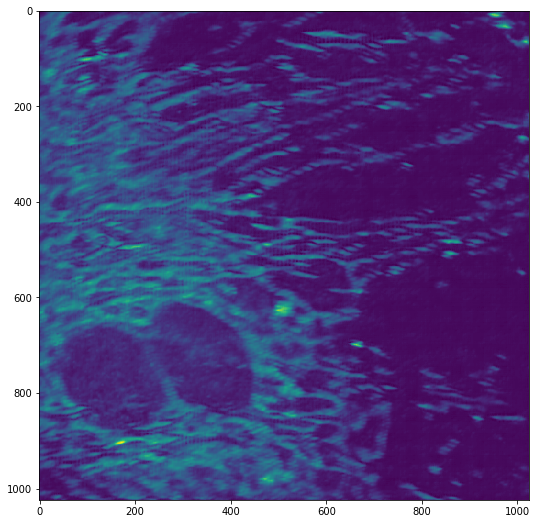

In [29]:
plt.figure(figsize=(9,9))
plt.imshow(result_img)

In [26]:
result_img.shape

(1024, 1024)

In [32]:
groundtruth_path = testset_path/f'input/highres'

In [33]:
gt_fns = list(sorted(groundtruth_path.ls()));

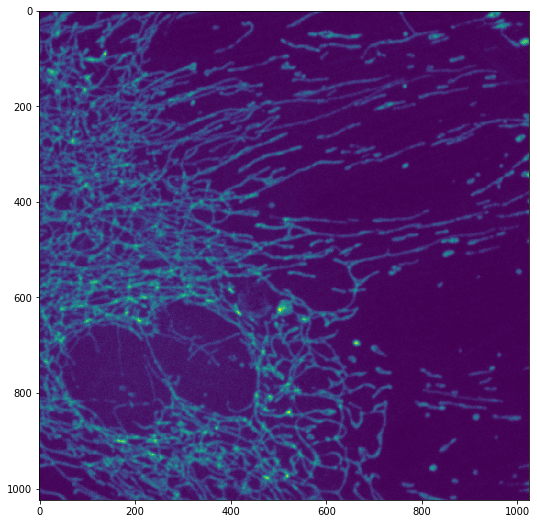

In [35]:
plt.figure(figsize=(9,9))
plt.imshow(plt.imread(gt_fns[0]))